# Covariance Intersection

[Covariance intersection](https://en.wikipedia.org/wiki/Covariance_intersection) is a way to combine two random variables without needing to know their correlations.

It generally preserves more variance than the usual combination of covariances.

Here I make no attempt to optimize the mixing parameter, w, I just use 0.5.  :-)

The WPI pose estimator treats X, Y, and theta as independent variables, so you can supply a variance for each, but you can't supply covariances.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

from numpy.linalg import inv

rng = np.random.default_rng(12345)

In [3]:
def confidence_ellipse(x, y, ax, n_std=3.0):
    cov = np.cov(x, y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse(
        (0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor="none",
        edgecolor="red",
    )

    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = (
        transforms.Affine2D()
        .rotate_deg(45)
        .scale(scale_x, scale_y)
        .translate(mean_x, mean_y)
    )

    ellipse.set_transform(transf + ax.transData)
    ax.add_patch(ellipse)

In [4]:
def get_multivariate_normal(mu, cov):
    x = rng.multivariate_normal(mu, cov, 1000)
    return x[:,0], x[:,1]

In [5]:
def make_plot(mu, cov, ax, title):
    x, y = get_multivariate_normal(mu, cov)
    ax.scatter(x, y, c="grey", s=0.25)
    confidence_ellipse(x, y, ax)
    ax.scatter(mu[0], mu[1], c="red", s=20)
    ax.axvline(c="grey", lw=1)
    ax.axhline(c="grey", lw=1)
    ax.set_aspect("equal")
    ax.set_xlim(-20, 20)
    ax.set_ylim(-20, 20)
    ax.set_title(
        # f"{title}\nmu=[{mu[0]:.1f},{mu[1]:.1f}]\n cov=[{cov[0][0]:.1f},{cov[0][1]:.1f}],\n[{cov[1][0]:.1f},{cov[1][1]:.1f}]"
        title
    )

# Combining random variables

The actual estimation errors tend to be aligned with the target -- the detector is really good at bearing, but not very good at range.  Imagine one target in the first quadrant, and another target in the second quadrant -- the shape of the estimates would be long and narrow, pointing at the targets.  The best estimate is the intersection of these regions, nowhere near their centers.

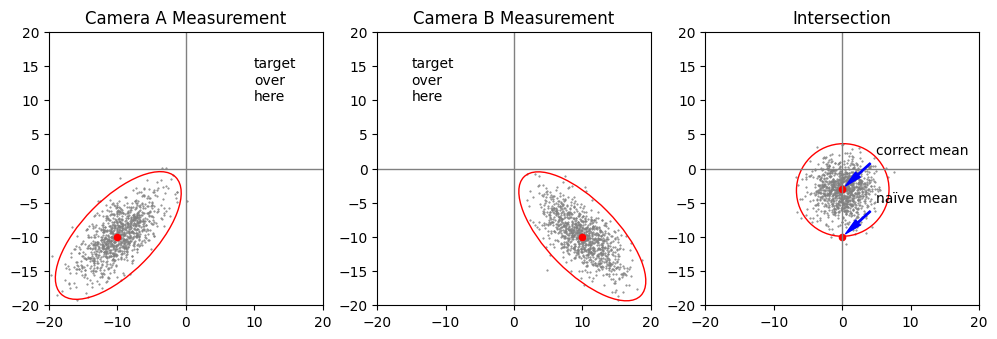

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
a = [-10, -10]
A = [[10, 7], [7, 10]]
ax[0].annotate("target\nover\nhere", [10,10])
make_plot(a, A, ax[0], "Camera A Measurement")

b = [10, -10]
B = [[10, -7], [-7, 10]]
ax[1].annotate("target\nover\nhere", [-15,10])
make_plot(b, B, ax[1], "Camera B Measurement")


naive_mean = (np.array(a)+np.array(b))/2
arrowprops = {'width':1,'headwidth':5,'shrink':0.1,'color':'blue'}
ax[2].scatter(naive_mean[0], naive_mean[1], c="red", s=20)
ax[2].annotate("naïve mean", naive_mean, naive_mean+[5,5],arrowprops=arrowprops)


w = 0.5
C = inv(w * inv(A) + (1 - w) * inv(B))
c = C.dot(w * inv(A).dot(a) + (1 - w) * inv(B).dot(b))
ax[2].annotate("correct mean", c, c+[5,5],arrowprops=arrowprops)
make_plot(c, C, ax[2], "Intersection")

plt.show()

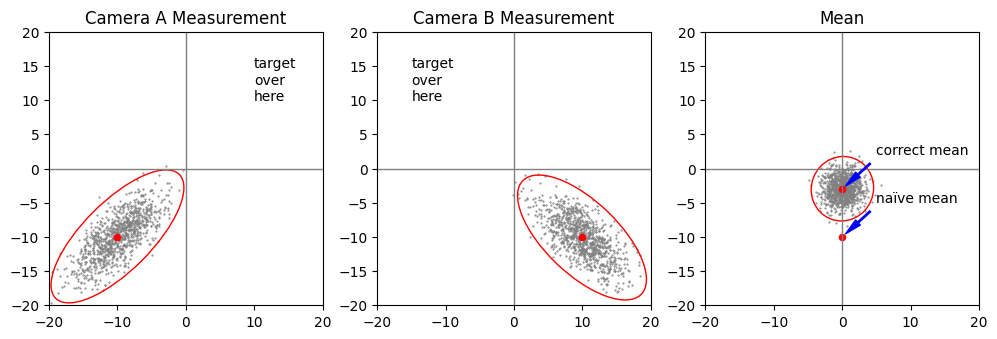

In [9]:
# The same thing, for the simple mean of independent measurements:

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
a = [-10, -10]
A = [[10, 7], [7, 10]]
ax[0].annotate("target\nover\nhere", [10,10])
make_plot(a, A, ax[0], "Camera A Measurement")

b = [10, -10]
B = [[10, -7], [-7, 10]]
ax[1].annotate("target\nover\nhere", [-15,10])
make_plot(b, B, ax[1], "Camera B Measurement")

naive_mean = (np.array(a)+np.array(b))/2
arrowprops = {'width':1,'headwidth':5,'shrink':0.1,'color':'blue'}
ax[2].scatter(naive_mean[0], naive_mean[1], c="red", s=20)
ax[2].annotate("naïve mean", naive_mean, naive_mean+[5,5],arrowprops=arrowprops)

# this is for *independent* estimates:
C = inv(inv(A) + inv(B))
c = C.dot(inv(A).dot(a) + inv(B).dot(b))
ax[2].annotate("correct mean", c, c+[5,5],arrowprops=arrowprops)
make_plot(c, C, ax[2], "Mean")

plt.show()

# References

* [An Information-Theoretic Justification for Covariance Intersection and Its Generalization, Hurley 2001](https://apps.dtic.mil/sti/tr/pdf/ADA394392.pdf)
  * "the covariance intersection technique selects a fused probability density function that is a log-linear combination of two initial probability density functions"

* [An Empirical Study into the Use of Chernoff Information for Robust, Distributed Fusion of Gaussian Mixture Models, Julier 2006](https://apps.dtic.mil/sti/tr/pdf/ADA498945.pdf)
* [a blog](https://github.com/CarstenSchelp/CarstenSchelp.github.io/blob/master/001_generate_plots.ipynb)
* [an example](https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html)
